In [1]:
from glob import glob
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
# third-party libraries
import dask
import dask.multiprocessing
import pandas as pd
import seaborn as sns
# local libraries
from fbd import get_permno_returns, read_parquet, get_monthly_returns, count_na
from fbd import START, END

In [2]:
# default setting for Dask
dask.config.set(scheduler='processes')
main_scheduler = 'processes'

In [3]:
filenames = glob('data/returns/raw/*.parquet')
dates_start = pd.date_range(START, END, freq='MS')
dates_dt = dates_start.strftime("%Y-%m")

# Data

## Matrix of Russell 3k constituents

In [4]:
const_mat = pd.read_csv('data/russell3000.csv.gz', compression='gzip',
                        index_col=0)

In [5]:
const_mat.sum(axis=1) # 3000 on each row

2010-01    3000.0
2010-02    3000.0
2010-03    3000.0
2010-04    3000.0
2010-05    3000.0
            ...  
2019-08    3000.0
2019-09    3000.0
2019-10    3000.0
2019-11    3000.0
2019-12    3000.0
Length: 120, dtype: float64

In [6]:
# create matrix of constituents where company is in Russell 3k lagged by one month 
# since we are using a one-month window for computing the risk factor models
const_mat_lag = const_mat.copy()
const_mat_lag.replace(0, np.nan, inplace=True)  # replace all 0s by nan
const_mat_lag.fillna(method='bfill', limit=1, inplace=True)
const_mat_lag.fillna(value=0, inplace=True)

In [7]:
const_mat_lag.sum(axis=1) # more than 3000 on each row

2010-01    3059.0
2010-02    3064.0
2010-03    3060.0
2010-04    3053.0
2010-05    3074.0
            ...  
2019-08    3060.0
2019-09    3053.0
2019-10    3055.0
2019-11    3055.0
2019-12    3000.0
Length: 120, dtype: float64

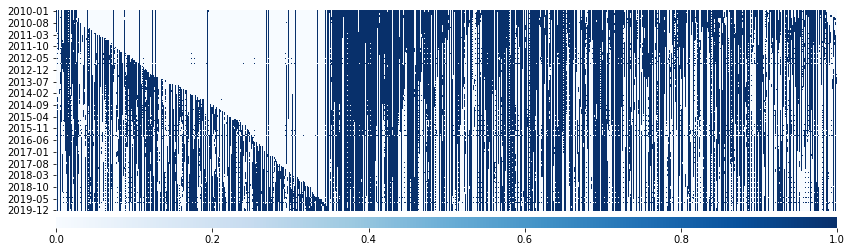

In [8]:
grid_kws = {"height_ratios": (.9, .05), "hspace": .05}
f, (ax, cbar_ax) = plt.subplots(2, figsize=(14, 4), gridspec_kw=grid_kws)
ax = sns.heatmap(const_mat, xticklabels=False, ax=ax, cbar_ax=cbar_ax, 
                 cbar_kws={"orientation": "horizontal"}, cmap='Blues')

## DataFrame containing information of each company

In [32]:
# get info matrix
info = pd.read_csv('data/permno_info.csv.gz', compression='gzip',
                   index_col=0)
info['permno'] = info['permno'].astype(int)

In [33]:
info.shape

(19067, 5)

In [34]:
info.head()

,permno,comnam,naics,siccd,ticker
0,10026,J & J SNACK FOODS CORP,NaN,2050.0,JJSF
1,10026,J & J SNACK FOODS CORP,NaN,2052.0,JJSF
2,10026,J & J SNACK FOODS CORP,311821.0,2052.0,JJSF
3,10026,J & J SNACK FOODS CORP,311813.0,2052.0,JJSF
4,10032,PLEXUS CORP,NaN,3670.0,PLXS


In [35]:
info.isna().sum()

permno       0
comnam       0
naics     6796
siccd      173
ticker     441
dtype: int64

## Some loading tests

In [13]:
%%time
with dask.config.set(scheduler=main_scheduler): 
    res = get_permno_returns('93419', const_mat)
    res = dask.compute(res)[0]

CPU times: user 211 ms, sys: 52.7 ms, total: 264 ms
Wall time: 1.61 s


<AxesSubplot:xlabel='date'>

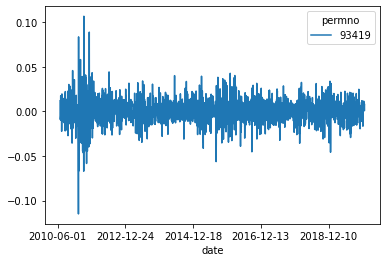

In [14]:
res.plot()

In [15]:
%%time
res = get_monthly_returns('2010-02', const_mat, months=2)

CPU times: user 576 ms, sys: 85.6 ms, total: 661 ms
Wall time: 485 ms


## Missing  values

In [16]:
%%time
# get missing values of each month where company is in Russell 3k (lagged by one month since we have downloaded 
# data as well one month prior to being un Russell 3k)
with dask.config.set(scheduler=main_scheduler): 
    promises = []
    for d in dates_dt:
        temp = dask.delayed(get_monthly_returns)(d, const_mat_lag, months=1)
        temp = dask.delayed(count_na)(temp, d)
        promises.append(temp)

    promises = dask.delayed(pd.concat)(promises)
    missing_lag = dask.compute(promises)[0]
    # re-order headers
    missing_lag = missing_lag.reindex(sorted(missing_lag.columns), axis=1)

CPU times: user 1.5 s, sys: 298 ms, total: 1.8 s
Wall time: 19.9 s


In [17]:
tot_missing_lag = missing_lag.sum().sum()
tot_missing_lag

35721.0

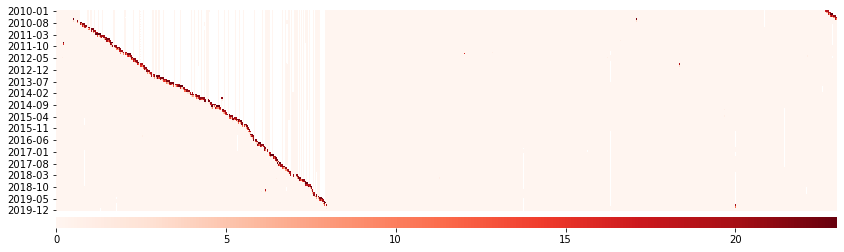

In [18]:
grid_kws = {"height_ratios": (.9, .05), "hspace": .05}
f, (ax, cbar_ax) = plt.subplots(2, figsize=(14, 4), gridspec_kw=grid_kws)
ax = sns.heatmap(missing_lag, xticklabels=False, ax=ax, cbar_ax=cbar_ax, 
                 cbar_kws={"orientation": "horizontal"}, cmap='Reds')

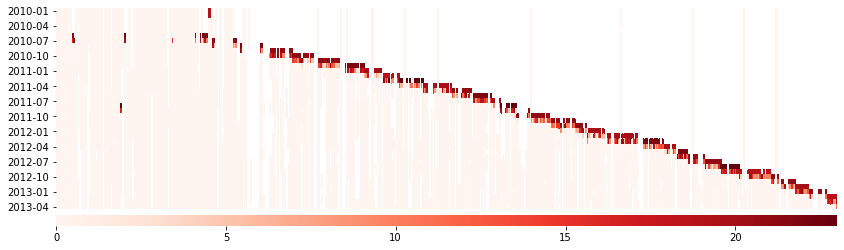

In [19]:
# zoom in on upper left corner
grid_kws = {"height_ratios": (.9, .05), "hspace": .05}
f, (ax, cbar_ax) = plt.subplots(2, figsize=(14, 4), gridspec_kw=grid_kws)
ax = sns.heatmap(missing_lag.iloc[0:40, 0:700], xticklabels=False, ax=ax, cbar_ax=cbar_ax, 
                 cbar_kws={"orientation": "horizontal"}, cmap='Reds')

In [20]:
%%time
# unlagged missing values
with dask.config.set(scheduler=main_scheduler): 
    promises = []
    for d in dates_dt:
        temp = dask.delayed(get_monthly_returns)(d, const_mat, months=1)
        temp = dask.delayed(count_na)(temp, d)
        promises.append(temp)

    promises = dask.delayed(pd.concat)(promises)
    missing = dask.compute(promises)[0]
    # re-order headers
    missing = missing.reindex(sorted(missing.columns), axis=1)

CPU times: user 1.53 s, sys: 311 ms, total: 1.84 s
Wall time: 19.8 s


In [21]:
tot_missing = missing.sum().sum()  # less missing values if we dont take into account data that has been downloaded one month 
# prior to entering Russell 3000
tot_missing

11996.0

In [22]:
tot_missing/3000/const_mat.shape[0]

0.033322222222222225

Text(0, 0.5, 'num. missing values')

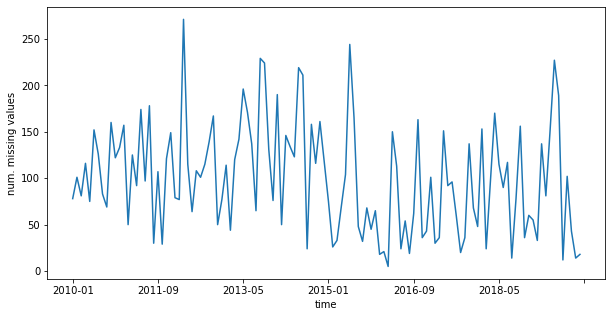

In [23]:
# plot total missing values over time
fig, ax = plt.subplots(figsize=(10, 5))
missing.sum(axis=1).plot(ax=ax)
ax.set_xlabel('time')
ax.set_ylabel('num. missing values')

In [24]:
%%time
# without dask
promises = []
for d in dates_dt:
    temp = get_monthly_returns(d, const_mat, months=1)
    temp = count_na(temp, d)
    promises.append(temp)
    
promises = pd.concat(promises)
# re-order headers
missing = missing.reindex(sorted(missing.columns), axis=1)

CPU times: user 46.8 s, sys: 3.48 s, total: 50.3 s
Wall time: 38.7 s


## Visualize Dask delayed

In [25]:
%%time
# unlagged missing values, create a small version for visualization purposes
promises = []
i = 0
with dask.config.set(scheduler=main_scheduler): 
    for d in dates_dt:
        temp = dask.delayed(get_monthly_returns)(d, const_mat, months=1)
        temp = dask.delayed(count_na)(temp, d)
        promises.append(temp)
        i += 1
        if i >= 10:
            break

    promises = dask.delayed(pd.concat)(promises)

CPU times: user 7.44 ms, sys: 3.7 ms, total: 11.1 ms
Wall time: 10.7 ms


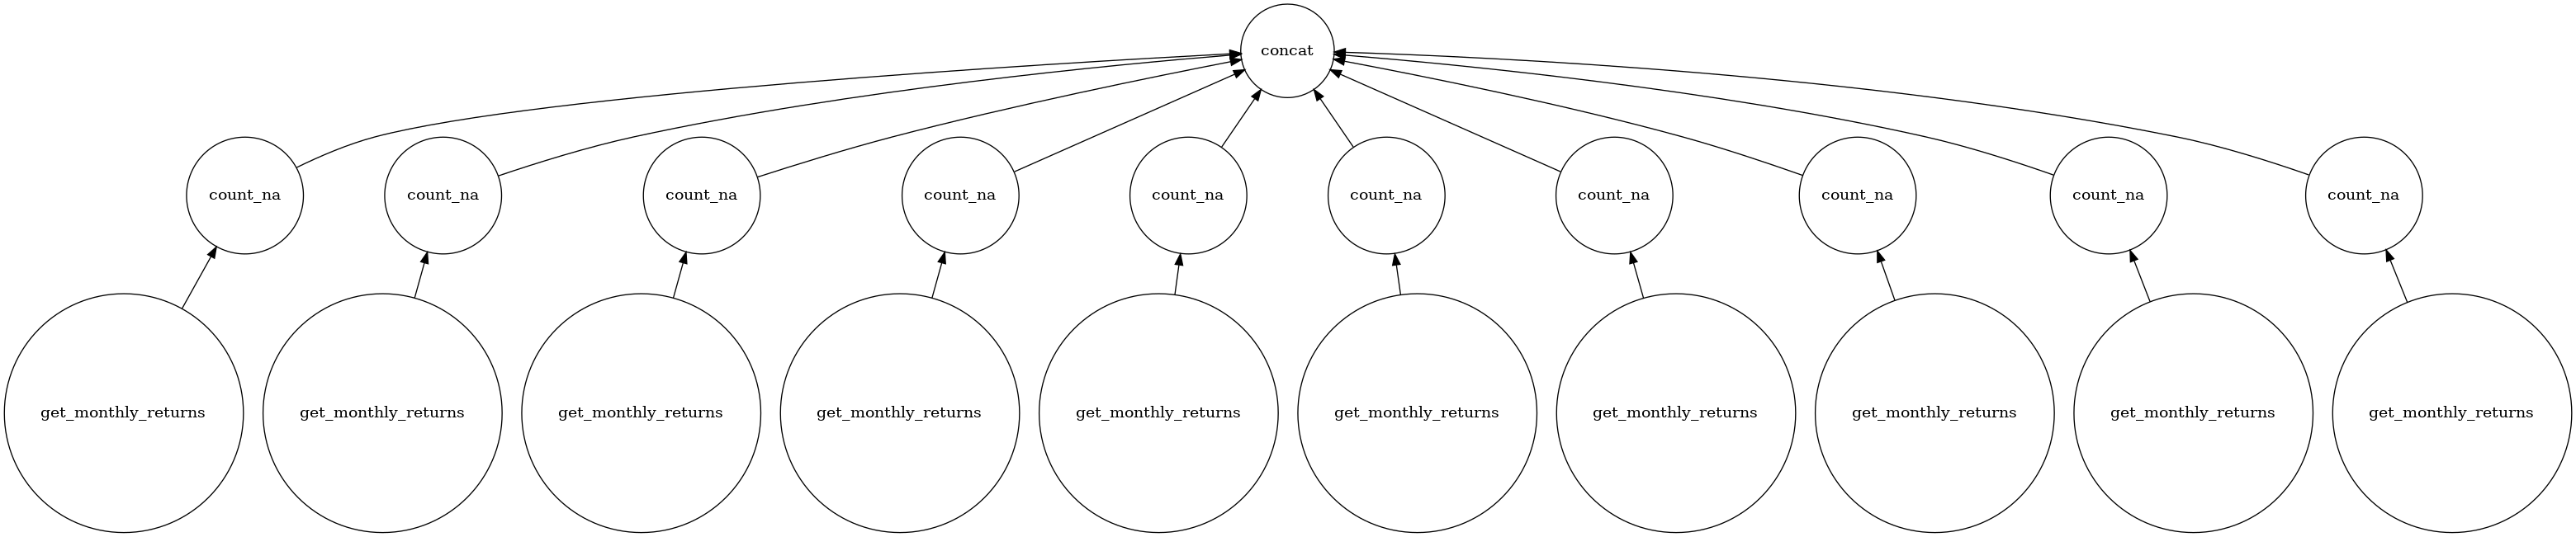

In [26]:
dask.visualize(promises, collapse_outputs=True, optimize_graph=True)

In [27]:
%%time
# get all data at once, faster using dask 
filenames = glob('data/returns/raw/*.parquet')
promises = [dask.delayed(read_parquet)(f) for f in filenames]
promises = dask.delayed(pd.concat)(promises)
all_data = dask.compute(promises)[0]

CPU times: user 851 ms, sys: 293 ms, total: 1.14 s
Wall time: 20.3 s


In [28]:
f'{tot_missing/all_data.size*100}%'

'0.08302081721385016%'

In [29]:
f'{tot_missing_lag/all_data.size*100}%'

'0.24721462251550033%'

## Fama-French

In [30]:
fama = pd.read_csv('data/fama/fama.csv.gz', compression='gzip', index_col=0)

In [31]:
fama.isna().sum()

Mkt-RF    0
SMB       0
HML       0
RMW       0
CMA       0
RF        0
Mom       0
ST_Rev    0
LT_Rev    0
dtype: int64